In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes

In [48]:
from itertools import count

SHAPE, SIZE = 0, 1
KINDS = {'square': ['s', 500], 'circle': ['o', 500], 'triangle': ['^', 500], 
         'star': ['*', 700], 'plus': ['p', 500], 'pentagon': ['p', 500], 'diamond': ['D', 400]}

class Station:
    __id_iter = count()
    all_stations = {}

    def __init__(self, x=None, y=None, kind=None):
        # If attribute not specified, pick randomly
        self.x = np.random.uniform() if x is None else x
        self.y = np.random.uniform() if y is None else y
        self.kind = np.random.choice(list(KINDS.keys())) if kind is None else kind
        
        assert(self.kind in KINDS)
        
        self.shape = KINDS[self.kind][SHAPE]
        self.size  = KINDS[self.kind][SIZE]
        
        self.id = next(Station.__id_iter)
        Station.all_stations[self.id] = self
        
    def __repr__(self):
        return str(self.id)

In [49]:
N = 5 # Stations

stations = [Station() for _ in range(N)]

In [50]:
from itertools import permutations

def distance(s1, s2):
    Δx = abs(s1.x - s2.x)
    Δy = abs(s1.y - s2.y)
    
    m = min(Δx, Δy)
    M = max(Δx, Δy)
    
    return M + (2**0.5 - 1) * m

def total_dist(rails):
    # Check if rails is just one rail
    if isinstance(rails[0], Station):
        rails = [rails]
        
    dist = 0
    for rail in rails:
        start = rail[0]
        for end in rail[1:]:
            dist += distance(start, end)
            start = end
            
    return dist

max_dist = 1e12
best = None

for perm in permutations(stations):
    perm = list(perm)
    perm.append(perm[0])
    
    dist = total_dist(perm)
    if dist < max_dist:
        max_dist = dist
        best = perm
        print(max_dist)
        print(perm)

2.822538712513663
[0, 1, 2, 3, 4, 0]
1.9547179099953471
[0, 1, 2, 4, 3, 0]
1.954717909995347
[2, 1, 0, 3, 4, 2]


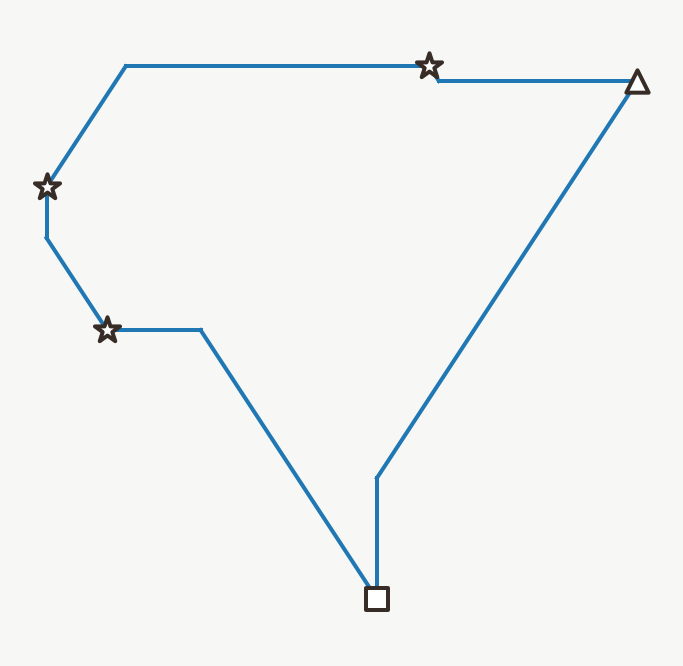

In [51]:
HORIZONTAL, VERTICAL = 0, 1

def draw(s1, s2, ax, c):
    #ax.plot([s1.x, s2.x], [s1.y, s2.y], lw=4, zorder=-1, c=c)
    
    Δx = s1.x - s2.x
    Δy = s1.y - s2.y
    
    lΔxl = abs(Δx)
    lΔyl = abs(Δy)
    
    m = min(lΔxl, lΔyl)
    M = max(lΔxl, lΔyl)
    
    straight = M - m
    
    alignment = HORIZONTAL if lΔxl >= lΔyl else VERTICAL
    dirx = np.sign(Δx)
    diry = np.sign(Δy)
    
    bendx = s1.x - dirx * (alignment == HORIZONTAL) * straight
    bendy = s1.y - diry * (alignment == VERTICAL  ) * straight
    
    # Straight
    ax.plot([s1.x, bendx], 
            [s1.y, bendy], lw=4, zorder=-1, c=c)
    
    # Bend
    ax.plot([bendx, s2.x], [bendy, s2.y], lw=4, zorder=-1, c=c)

def graph(stations, rails):
    # Check if only one rail
    if isinstance(rails[0], Station):
        rails = [rails]
    
    fig, ax = plt.subplots(figsize=(12, 12))

    for i, rail in enumerate(rails):
        start = rail[0]
        for end in rail[1:]:
            draw(start, end, ax, f'C{i}')
            start = end

    
    for s in stations:
        ax.scatter(s.x, s.y, marker=s.shape, s=s.size, c='white', edgecolor='#382c27', linewidth=4)

    fig.set_facecolor('#f7f7f5')
    ax.axis('off')

    ax.set_xlim(min(s.x for s in stations)-0.05, max(s.x for s in stations) + 0.05)
    ax.set_ylim(min(s.y for s in stations)-0.05, max(s.y for s in stations) + 0.05)

    plt.show()
    
graph(stations, best)

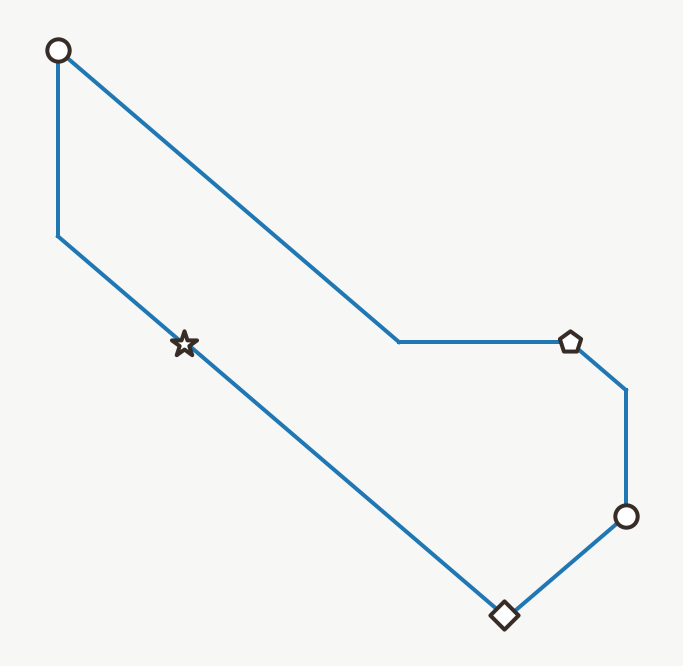

In [27]:
graph(stations, best)